In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 讀取資料
df = pd.read_csv('data/CA_Weather_Fire_Dataset_1984-2025.csv')

df.head(5)
DAY_DROP =1
YEAR_DROP = 1
Weight_Balance = 0
Tryname = 'd1y1wb0' #balance weight



In [2]:
df.describe()


,PRECIPITATION,MAX_TEMP,MIN_TEMP,AVG_WIND_SPEED,YEAR,TEMP_RANGE,WIND_TEMP_RATIO,MONTH,LAGGED_PRECIPITATION,LAGGED_AVG_WIND_SPEED,DAY_OF_YEAR
count,14987.000000,14987.000000,14987.000000,14976.000000,14988.000000,14987.000000,14976.000000,14988.000000,14988.000000,14988.000000,14988.000000
mean,0.032315,70.534997,56.494095,7.435098,2004.016813,14.040902,0.107019,6.518281,0.226188,7.434198,182.992994
std,0.179544,7.263447,6.767685,2.129985,11.843342,5.995327,0.035630,3.451037,0.648705,1.387849,105.523627
min,0.000000,50.000000,33.000000,1.790000,1984.000000,2.000000,0.023553,1.000000,0.000000,3.227143,1.000000
25%,0.000000,65.000000,51.000000,6.040000,1994.000000,10.000000,0.085238,4.000000,0.000000,6.518571,92.000000
50%,0.000000,70.000000,57.000000,7.160000,2004.000000,12.000000,0.102222,7.000000,0.000000,7.478571,183.000000
75%,0.000000,75.000000,62.000000,8.500000,2014.000000,17.000000,0.120462,10.000000,0.060000,8.278571,274.000000
max,4.530000,106.000000,77.000000,26.170000,2025.000000,41.000000,0.459123,12.000000,8.180000,13.932857,366.000000


| 欄位名稱               | 說明                                                                 |
|------------------------|----------------------------------------------------------------------|
| DATE                   | 當天的觀測日期                                                       |
| PRECIPITATION          | 每日降水量（英吋）                                                   |
| MAX_TEMP               | 每日最高氣溫（華氏）                                                 |
| MIN_TEMP               | 每日最低氣溫（華氏）                                                 |
| AVG_WIND_SPEED         | 每日平均風速（英里/小時）                                           |
| FIRE_START_DAY         | 是否於該日發生野火（布林值：True/False）                            |
| YEAR                   | 年份                                                                 |
| TEMP_RANGE             | 當日最高與最低溫差，反映氣溫變化程度                                |
| WIND_TEMP_RATIO        | 平均風速與最高溫度的比值，捕捉風與溫度間的動態關係                  |
| MONTH                  | 月份（1–12）                                                        |
| SEASON                 | 季節（Winter, Spring, Summer, Fall）                                |
| LAGGED_PRECIPITATION   | 前 7 天的累積降水量，反映近一週的濕潤條件                            |
| LAGGED_AVG_WIND_SPEED  | 前 7 天的平均風速，反映持續的風力狀況                                |
| DAY_OF_YEAR            | 當年度中的天數（1–365 或 366）                                     |


<h5>

- 對月份做 sin/cos 轉換  保留了數值間的連續性與週期性。
  
- 1 月與 12 月其實很接近，但 get_dummies() 會把它們視為完全無關。

- 而 sin/cos 轉換會保留這種「循環性」。

</h5>

In [3]:
import numpy as np

df['MONTH_SIN'] = np.sin(2 * np.pi * df['MONTH'] / 12)
df['MONTH_COS'] = np.cos(2 * np.pi * df['MONTH'] / 12)
if DAY_DROP == 0:
    df['DOY_SIN'] = np.sin(2 * np.pi * df['DAY_OF_YEAR'] / 366)
    df['DOY_COS'] = np.cos(2 * np.pi * df['DAY_OF_YEAR'] / 366)

# 將 FIRE_START_DAY 轉為整數型（0 或 1）
df['FIRE_START_DAY'] = df['FIRE_START_DAY'].astype(int)

<h5>

- `PRECIPITATION`幾乎所有值都是 0（沒下雨），只有極少數是非零，所以我們轉成是否有下雨 

- `TEMP_MEAN` 溫度範圍（TEMP_RANGE）差異滿大的，從 2 到 41，直接用溫度平均值，有時比分開的 MAX、MIN 更有區分力。

</h5>

In [4]:
df['IS_RAINING'] = (df['PRECIPITATION'] > 0).astype(int) #幾乎所有值都是 0（沒下雨），只有極少數是非零。
df['TEMP_MEAN'] = (df['MAX_TEMP'] + df['MIN_TEMP'] / 2).astype(float) #溫度範圍（TEMP_RANGE）差異滿大的，從 2 到 41，直接用溫度平均值，有時比分開的 MAX、MIN 更有區分力。
#df = df.drop(columns=['MAX_TEMP', 'MIN_TEMP','LAGGED_PRECIPITATION'])

In [5]:

df.describe()

,PRECIPITATION,MAX_TEMP,MIN_TEMP,AVG_WIND_SPEED,FIRE_START_DAY,YEAR,TEMP_RANGE,WIND_TEMP_RATIO,MONTH,LAGGED_PRECIPITATION,LAGGED_AVG_WIND_SPEED,DAY_OF_YEAR,MONTH_SIN,MONTH_COS,IS_RAINING,TEMP_MEAN
count,14987.000000,14987.000000,14987.000000,14976.000000,14988.000000,14988.000000,14987.000000,14976.000000,14988.000000,14988.000000,14988.000000,14988.000000,1.498800e+04,1.498800e+04,14988.000000,14987.000000
mean,0.032315,70.534997,56.494095,7.435098,0.331665,2004.016813,14.040902,0.107019,6.518281,0.226188,7.434198,182.992994,-4.336929e-03,-1.308696e-03,0.092140,98.782044
std,0.179544,7.263447,6.767685,2.129985,0.470827,11.843342,5.995327,0.035630,3.451037,0.648705,1.387849,105.523627,7.056530e-01,7.085902e-01,0.289234,9.773213
min,0.000000,50.000000,33.000000,1.790000,0.000000,1984.000000,2.000000,0.023553,1.000000,0.000000,3.227143,1.000000,-1.000000e+00,-1.000000e+00,0.000000,68.500000
25%,0.000000,65.000000,51.000000,6.040000,0.000000,1994.000000,10.000000,0.085238,4.000000,0.000000,6.518571,92.000000,-8.660254e-01,-8.660254e-01,0.000000,91.500000
50%,0.000000,70.000000,57.000000,7.160000,0.000000,2004.000000,12.000000,0.102222,7.000000,0.000000,7.478571,183.000000,-2.449294e-16,-1.836970e-16,0.000000,99.000000
75%,0.000000,75.000000,62.000000,8.500000,1.000000,2014.000000,17.000000,0.120462,10.000000,0.060000,8.278571,274.000000,5.000000e-01,8.660254e-01,0.000000,105.500000
max,4.530000,106.000000,77.000000,26.170000,1.000000,2025.000000,41.000000,0.459123,12.000000,8.180000,13.932857,366.000000,1.000000e+00,1.000000e+00,1.000000,141.000000


- 根據[NOAA](https://www.noaa.gov/noaa-wildfire)
- 和[Climate](https://www.climate.gov/news-features/event-tracker/weather-and-climate-influences-january-2025-fires-around-los-angeles)

- 1. 氣溫變異指數（Temperature Variation Index）  

| **項目**      | **內容**                                                                                   |
|---------------|--------------------------------------------------------------------------------------------|
| **定義**      | 每日氣溫的變異程度，反映當天最高和最低氣溫之間的差異。較大的溫差可能與氣候極端性相關，進一步加劇火災風險。 |
| **公式**      | `TEMP_VARIATION = MAX_TEMP - MIN_TEMP`                                                     |

- 2. 降水與風速比率（Precipitation-Wind Ratio）  

| **項目**      | **內容**                                                                                   |
|---------------|--------------------------------------------------------------------------------------------|
| **定義**      | 衡量降水量與風速之間的關聯。當降水量低且風速高時，通常意味著乾燥條件與強風並存，火災風險上升。            |
| **公式**      | `PRECIPITATION_WIND_RATIO = PRECIPITATION / AVG_WIND_SPEED`                                |

- 3. 季節性降水與風速關聯指數（Seasonal Precipitation-Wind Index）  

| **項目**      | **內容**                                                                                   |
|---------------|--------------------------------------------------------------------------------------------|
| **定義**      | 綜合考量季節（SEASON）對降水與風速影響的指標。不同季節降水和風速的組合，會對火災風險產生不同作用。          |
| **公式**      | `SEASONAL_PRECIP_WIND = (PRECIPITATION * (SEASON == 'Winter')) + (AVG_WIND_SPEED * (SEASON == 'Summer'))` |

- 4. 季節性乾燥指數（Seasonal Dryness Index）  

| **項目**      | **內容**                                                                                   |
|---------------|--------------------------------------------------------------------------------------------|
| **定義**      | 根據當季（秋季或冬季）的降水量與日溫差來評估乾燥程度。乾燥季節中的高乾燥值與火災風險高度相關。             |
| **公式**      | `SEASONAL_DRYNESS = (PRECIPITATION * (SEASON == 'Fall' or SEASON == 'Winter')) / (MAX_TEMP - MIN_TEMP)` |

- 5. 日中溫差與風速結合指數（Diurnal Temperature and Wind Speed Index） 

| **項目**      | **內容**                                                                                   |
|---------------|--------------------------------------------------------------------------------------------|
| **定義**      | 此指標將每日的氣溫差（即日間溫度變化）與風速結合，評估乾燥和高風速的條件下，火災風險的潛在性。            |
| **公式**      | `DIURNAL_TEMP_WIND = (MAX_TEMP - MIN_TEMP) * AVG_WIND_SPEED` |


In [6]:
#--------------------------------------
# 我分析而得的衍生指標 :




df['PRECIPITATION_WIND_RATIO'] = df['PRECIPITATION'] / df['AVG_WIND_SPEED']
df['SEASONAL_PRECIP_WIND'] = (df['PRECIPITATION'] * (df['SEASON'] == 'Winter')) + (df['AVG_WIND_SPEED'] * (df['SEASON'] == 'Summer'))
df['SEASONAL_DRYNESS'] = (df['PRECIPITATION'] * ((df['SEASON'] == 'Fall') | (df['SEASON'] == 'Winter'))) / (df['MAX_TEMP'] - df['MIN_TEMP'])
df['DIURNAL_TEMP_WIND'] = (df['MAX_TEMP'] - df['MIN_TEMP']) * df['AVG_WIND_SPEED']



# One-Hot Encoding: SEASON
df = pd.get_dummies(df, columns=['SEASON'])
season_cols = ['SEASON_Fall', 'SEASON_Spring', 'SEASON_Summer', 'SEASON_Winter']
df[season_cols] = df[season_cols].astype(int)

In [7]:
LSdf = df
df = df.drop(columns=['DATE', 'MONTH', 'DAY_OF_YEAR'])
if YEAR_DROP == 1:
    df = df.drop(columns=['YEAR']) # 這個是我們要預測的目標變數

In [8]:
# 特徵與目標分離
X = df.drop(['FIRE_START_DAY'], axis=1)
y = df['FIRE_START_DAY']

In [9]:
print(X.isna().sum())
X = X.fillna(X.median())
assert X.isna().sum().sum() == 0, "There are still missing values in the dataset."

PRECIPITATION                1
MAX_TEMP                     1
MIN_TEMP                     1
AVG_WIND_SPEED              12
TEMP_RANGE                   1
WIND_TEMP_RATIO             12
LAGGED_PRECIPITATION         0
LAGGED_AVG_WIND_SPEED        0
MONTH_SIN                    0
MONTH_COS                    0
IS_RAINING                   0
TEMP_MEAN                    1
PRECIPITATION_WIND_RATIO    12
SEASONAL_PRECIP_WIND        12
SEASONAL_DRYNESS             1
DIURNAL_TEMP_WIND           12
SEASON_Fall                  0
SEASON_Spring                0
SEASON_Summer                0
SEASON_Winter                0
dtype: int64


2. 數值特徵標準化（Standardization）
為避免某些欄位（如溫度或風速）對模型訓練造成不公平的權重，我們可以對所有數值特徵做 **Z-score** 標準化 **（均值為0，標準差為1）**，但不包含 One-Hot 欄位。

In [10]:
'''
from sklearn.preprocessing import StandardScaler

# 找出所有數值欄位（排除 one-hot 和目標變數）
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns

# 建立標準化物件並套用於訓練集和測試集
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
'''

"\nfrom sklearn.preprocessing import StandardScaler\n\n# 找出所有數值欄位（排除 one-hot 和目標變數）\nnumeric_cols = X.select_dtypes(include=['float64', 'int64']).columns\n\n# 建立標準化物件並套用於訓練集和測試集\nscaler = StandardScaler()\nX[numeric_cols] = scaler.fit_transform(X[numeric_cols])\n"

In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14988 entries, 0 to 14987
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   PRECIPITATION             14988 non-null  float64
 1   MAX_TEMP                  14988 non-null  float64
 2   MIN_TEMP                  14988 non-null  float64
 3   AVG_WIND_SPEED            14988 non-null  float64
 4   TEMP_RANGE                14988 non-null  float64
 5   WIND_TEMP_RATIO           14988 non-null  float64
 6   LAGGED_PRECIPITATION      14988 non-null  float64
 7   LAGGED_AVG_WIND_SPEED     14988 non-null  float64
 8   MONTH_SIN                 14988 non-null  float64
 9   MONTH_COS                 14988 non-null  float64
 10  IS_RAINING                14988 non-null  int64  
 11  TEMP_MEAN                 14988 non-null  float64
 12  PRECIPITATION_WIND_RATIO  14988 non-null  float64
 13  SEASONAL_PRECIP_WIND      14988 non-null  float64
 14  SEASON

### 切割資料集

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [13]:
print(y.value_counts(normalize=True))

FIRE_START_DAY
0    0.668335
1    0.331665
Name: proportion, dtype: float64


In [14]:
X_train.head(5) 

,PRECIPITATION,MAX_TEMP,MIN_TEMP,AVG_WIND_SPEED,TEMP_RANGE,WIND_TEMP_RATIO,LAGGED_PRECIPITATION,LAGGED_AVG_WIND_SPEED,MONTH_SIN,MONTH_COS,IS_RAINING,TEMP_MEAN,PRECIPITATION_WIND_RATIO,SEASONAL_PRECIP_WIND,SEASONAL_DRYNESS,DIURNAL_TEMP_WIND,SEASON_Fall,SEASON_Spring,SEASON_Summer,SEASON_Winter
11798,0.0,81.0,59.0,7.61,22.0,0.093951,0.00,8.277143,0.866025,-0.500000,0,110.5,0.0,0.00,0.0,167.42,0,1,0,0
4885,0.0,74.0,63.0,8.50,11.0,0.114865,0.00,7.414286,0.500000,-0.866025,0,105.5,0.0,0.00,0.0,93.50,0,1,0,0
1572,0.0,64.0,50.0,8.50,14.0,0.132812,0.68,10.674286,0.866025,-0.500000,0,89.0,0.0,0.00,0.0,119.00,0,1,0,0
12985,0.0,72.0,63.0,10.07,9.0,0.139861,0.00,8.245714,-0.500000,-0.866025,0,103.5,0.0,10.07,0.0,90.63,0,0,1,0
879,0.0,71.0,60.0,8.05,11.0,0.113380,0.00,7.350000,0.500000,-0.866025,0,101.0,0.0,0.00,0.0,88.55,0,1,0,0


In [15]:
import mlflow
from mlflow.tracking.client import MlflowClient
mlflow.set_experiment("CA_Weather_Fire_0505")

2025/05/05 11:36:50 INFO mlflow.tracking.fluent: Experiment with name 'CA_Weather_Fire_0505' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///c:/Users/ygz08/Desktop/Git/localgit/MLOPs/Predictable_wildfire/mlruns/498119347864726743', creation_time=1746416210077, experiment_id='498119347864726743', last_update_time=1746416210077, lifecycle_stage='active', name='CA_Weather_Fire_0505', tags={}>

<hr>

## LogisticRegression

<h5>

- 本模型使用 scikit-learn 的邏輯迴歸進行二元分類，適合處理線性可分的問題。

- 採用 class_weight='balanced' 自動調整類別權重，改善不平衡資料的預測表現。

- 輸入為數值特徵向量，經 sigmoid 函數輸出分類機率，訓練過程簡潔高效。

</h5>

In [16]:
from sklearn.linear_model import LogisticRegression

run_name = Tryname + '_LogisticRegression'

with mlflow.start_run(run_name=run_name):#mlflow
    mlflow.tensorflow.autolog()#mlflow
    max_iter=1000 
    if Weight_Balance == 1:
        log_reg = LogisticRegression(max_iter=max_iter, class_weight='balanced')
    else:
        log_reg = LogisticRegression(max_iter=max_iter, class_weight=None)
    log_reg.fit(X_train, y_train)
    run_id = mlflow.active_run().info.run_id#mlflow
    print(f"Model saved in run {run_id}")#mlflow
    

    # 檢查訓練與測試分數
    print("Train score:", log_reg.score(X_train, y_train))
    print("Test score:", log_reg.score(X_test, y_test))

    mlflow.log_metric("Train score", log_reg.score(X_train, y_train))#mlflow
    mlflow.log_metric("Test score", log_reg.score(X_test, y_test))#mlflow


    # 存檔模型mlflow
    model_name = "LogisticRegression-model"
    mlflow.sklearn.log_model(     #mlflow.sklearn.log_model() #紀錄sklearn模型
        sk_model=log_reg, 
        artifact_path="LogisticRegression-model",
        registered_model_name=model_name,  #
    )

    from sklearn.metrics import classification_report
    report_dict = classification_report(y_test, log_reg.predict(X_test), output_dict=True)
    print(report_dict)
    for label, metrics in report_dict.items():
        if isinstance(metrics, dict):  # 各分類或 avg 區段
            for metric_name, value in metrics.items():
                metric_key = f"{label}_{metric_name}".replace(" ", "_")  # 去除空格
                mlflow.log_metric(metric_key, value)
        elif isinstance(metrics, (int, float)):  # accuracy 是 float
            mlflow.log_metric(label, metrics)

C:\Users\ygz08\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model saved in run 437a440205b5421fbec803ed938803e8
Train score: 0.7739014393289486
Test score: 0.7782966422059151


2025/05/05 11:36:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


{'0': {'precision': 0.8289473684210527, 'recall': 0.8477190679356744, 'f1-score': 0.8382281356482233, 'support': 3047.0}, '1': {'precision': 0.664011585807386, 'recall': 0.6324137931034483, 'f1-score': 0.6478276227481455, 'support': 1450.0}, 'accuracy': 0.7782966422059151, 'macro avg': {'precision': 0.7464794771142194, 'recall': 0.7400664305195613, 'f1-score': 0.7430278791981844, 'support': 4497.0}, 'weighted avg': {'precision': 0.7757659397375266, 'recall': 0.7782966422059151, 'f1-score': 0.7768359311329659, 'support': 4497.0}}


Registered model 'LogisticRegression-model' already exists. Creating a new version of this model...
Created version '26' of model 'LogisticRegression-model'.


<hr>

## Random Forest

<h5>

- 本模型採用隨機森林進行二元分類，適用於處理非線性與特徵互動的問題。

- 使用 150 顆決策樹與最大深度 15，並搭配 class_weight='balanced' 處理類別不平衡。

- 模型可直接處理數值特徵，透過多樹投票提升穩定性與泛化能力。

</h5>

In [17]:
from sklearn.ensemble import RandomForestClassifier

run_name = Tryname + '_RandomForest'

with mlflow.start_run(run_name=run_name):#mlflow
    mlflow.tensorflow.autolog()#mlflow
    if Weight_Balance == 1:
        rf = RandomForestClassifier(n_estimators=150, max_depth=15, class_weight='balanced')
    else:
        rf = RandomForestClassifier(n_estimators=150, max_depth=15, class_weight=None)
    rf.fit(X_train, y_train)
    run_id = mlflow.active_run().info.run_id#mlflow
    print(f"Model saved in run {run_id}")#mlflow
    

    # 檢查訓練與測試分數
    print("Train score:", rf.score(X_train, y_train))
    print("Test score:", rf.score(X_test, y_test))

    mlflow.log_metric("Train score", rf.score(X_train, y_train))#mlflow
    mlflow.log_metric("Test score", rf.score(X_test, y_test))#mlflow


    # 存檔模型mlflow
    model_name = "RandomForest-model"
    mlflow.sklearn.log_model(     #mlflow.sklearn.log_model() #紀錄sklearn模型
        sk_model=rf, 
        artifact_path="RandomForest-model",
        registered_model_name=model_name,  #
    )
    
    from sklearn.metrics import classification_report
    report_dict = classification_report(y_test, rf.predict(X_test), output_dict=True)
    print(report_dict)
    for label, metrics in report_dict.items():
        if isinstance(metrics, dict):  # 各分類或 avg 區段
            for metric_name, value in metrics.items():
                metric_key = f"{label}_{metric_name}".replace(" ", "_")  # 去除空格
                mlflow.log_metric(metric_key, value)
        elif isinstance(metrics, (int, float)):  # accuracy 是 float
            mlflow.log_metric(label, metrics)


Model saved in run f3b3de3e71af437c8ec66e5d5d99016e
Train score: 0.9165951768182251
Test score: 0.771847898599066


2025/05/05 11:37:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


{'0': {'precision': 0.8262835001614466, 'recall': 0.8398424680013128, 'f1-score': 0.8330078125, 'support': 3047.0}, '1': {'precision': 0.6514285714285715, 'recall': 0.6289655172413793, 'f1-score': 0.64, 'support': 1450.0}, 'accuracy': 0.771847898599066, 'macro avg': {'precision': 0.738856035795009, 'recall': 0.734403992621346, 'f1-score': 0.7365039062500001, 'support': 4497.0}, 'weighted avg': {'precision': 0.7699037699718382, 'recall': 0.771847898599066, 'f1-score': 0.7707749176534356, 'support': 4497.0}}


Registered model 'RandomForest-model' already exists. Creating a new version of this model...
Created version '19' of model 'RandomForest-model'.


### 模型評估 :
- Before Tuning
  - **Train score: 1.0**
  - **Test score: 0.7883033133199912**
  - **accuracy  0.79**

✅ 模型優勢
- 對無火災類別（0）有較高的 precision 和 recall，尤其 recall 高達 0.88，模型能夠準確地識別大部分「無火災」的情況。
- f1-score 達到了 0.85，代表模型對「無火災」的預測表現非常好。

⚠️ 模型的挑戰
- 對有火災（1）類別，precision 是 0.70，而 recall 只有 0.60，這意味著：
    - 對有火災的預測還有進步空間，模型錯過了一部分火災案例，這對於防火系統來說是很關鍵的。

In [18]:
# Tuned Random Forest¶
from sklearn.model_selection import  RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Set up the search
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='roc_auc',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit search
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 5, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, scoring='roc_auc', verbose=1)

In [19]:
# Get the best model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
best_rf = random_search.best_estimator_

# Predict
y_pred_best_rf = best_rf.predict(X_test)
y_proba_best_rf = best_rf.predict_proba(X_test)[:, 1]

# Evaluation
print("--- Best Random Forest (Tuned) ---")
print("Classification Report:\n", classification_report(y_test, y_pred_best_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best_rf))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_best_rf))

--- Best Random Forest (Tuned) ---
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.85      0.84      3047
           1       0.66      0.62      0.64      1450

    accuracy                           0.77      4497
   macro avg       0.74      0.74      0.74      4497
weighted avg       0.77      0.77      0.77      4497

Confusion Matrix:
 [[2578  469]
 [ 544  906]]
ROC AUC Score: 0.8316814730147234


### 結果分析：
- After Tuning
  - **accuracy  0.8**
  - **ROC AUC  0.858**

<hr>

## XG Boosting

<h5>

- 採用 XGBoost 分類器進行二元分類，具備強大處理非線性資料的能力。

- 模型結合 100 顆深度為 6 的樹，搭配 L1/L2 正則化與學習率調整以防止過擬合。

- 使用 class_weight='balanced' 解決類別不平衡問題，提升模型泛化能力。

</h5>

In [20]:
from xgboost import XGBClassifier
#Train score: 0.9090649127823849
#Test score: 0.7820769401823437

run_name = Tryname + '_XGBClassifier'

with mlflow.start_run(run_name=run_name):#mlflow
    mlflow.tensorflow.autolog()#mlflow
    max_iter=1000 
    #mlflow.log_param("max_iter", max_iter) #mlflow紀錄參數n_estimators
# 方法四：使用 class_weight='balanced'
    if Weight_Balance == 1:
        xgb_model = XGBClassifier(
            random_state=42, 
            class_weight='balanced',  # 對不平衡數據進行調整
            alpha=0.1,  # L1 正則化強度，通常設為較小的正值
            lambda_=1.0,  # L2 正則化強度，默認為1
            n_estimators=100,  # 樹的數量
            max_depth=6,  # 每棵樹的最大深度
            learning_rate=0.1  # 學習率
        )
    else:
        xgb_model = XGBClassifier(
            random_state=42, 
            alpha=0.1,  # L1 正則化強度，通常設為較小的正值
            lambda_=1.0,  # L2 正則化強度，默認為1
            n_estimators=100,  # 樹的數量
            max_depth=6,  # 每棵樹的最大深度
            learning_rate=0.1  # 學習率
        )
    xgb_model.fit(X_train, y_train)
    run_id = mlflow.active_run().info.run_id#mlflow
    print(f"Model saved in run {run_id}")#mlflow
    

    # 檢查訓練與測試分數
    print("Train score:", xgb_model.score(X_train, y_train))
    print("Test score:", xgb_model.score(X_test, y_test))

    mlflow.log_metric("Train score", xgb_model.score(X_train, y_train))#mlflow
    mlflow.log_metric("Test score", xgb_model.score(X_test, y_test))#mlflow


    # 存檔模型mlflow
    model_name = "XGBClassifier-model"
    mlflow.sklearn.log_model(     #mlflow.sklearn.log_model() #紀錄sklearn模型
        sk_model=xgb_model, 
        artifact_path="XGBClassifier-model",
        registered_model_name=model_name,  #
    )

    from sklearn.metrics import classification_report
    report_dict = classification_report(y_test, xgb_model.predict(X_test), output_dict=True)
    print(report_dict)
    for label, metrics in report_dict.items():
        if isinstance(metrics, dict):  # 各分類或 avg 區段
            for metric_name, value in metrics.items():
                metric_key = f"{label}_{metric_name}".replace(" ", "_")  # 去除空格
                mlflow.log_metric(metric_key, value)
        elif isinstance(metrics, (int, float)):  # accuracy 是 float
            mlflow.log_metric(label, metrics)

C:\Users\ygz08\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [11:37:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "lambda_" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model saved in run 0d97678cb102448eb1a2927cdfa0e35e
Train score: 0.8149842722333429
Test score: 0.7758505670446965


2025/05/05 11:37:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


{'0': {'precision': 0.831760494630654, 'recall': 0.8388578930095175, 'f1-score': 0.8352941176470589, 'support': 3047.0}, '1': {'precision': 0.6551966292134831, 'recall': 0.643448275862069, 'f1-score': 0.6492693110647182, 'support': 1450.0}, 'accuracy': 0.7758505670446965, 'macro avg': {'precision': 0.7434785619220685, 'recall': 0.7411530844357932, 'f1-score': 0.7422817143558885, 'support': 4497.0}, 'weighted avg': {'precision': 0.7748297397151775, 'recall': 0.7758505670446965, 'f1-score': 0.7753128035388991, 'support': 4497.0}}


Registered model 'XGBClassifier-model' already exists. Creating a new version of this model...
Created version '20' of model 'XGBClassifier-model'.


### SHAP（SHapley Additive exPlanations）

- 是一種解釋模型預測的工具，告訴你每個特徵對於每一筆資料的預測「貢獻度」。

C:\Users\ygz08\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 97%|=================== | 4384/4497 [00:11<00:00]       

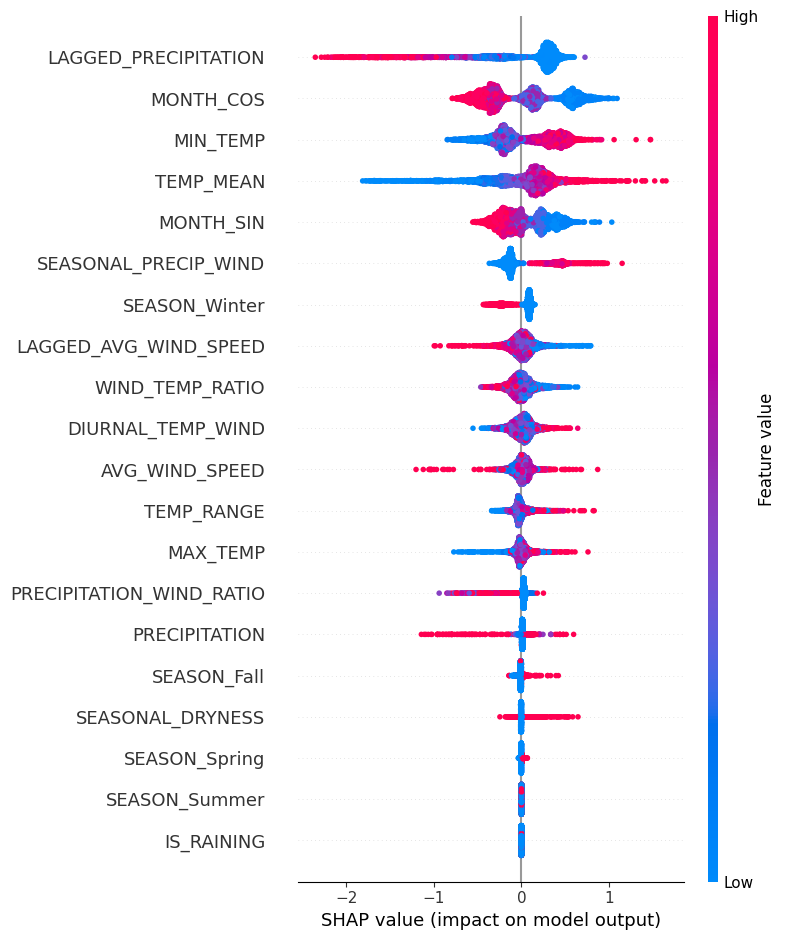

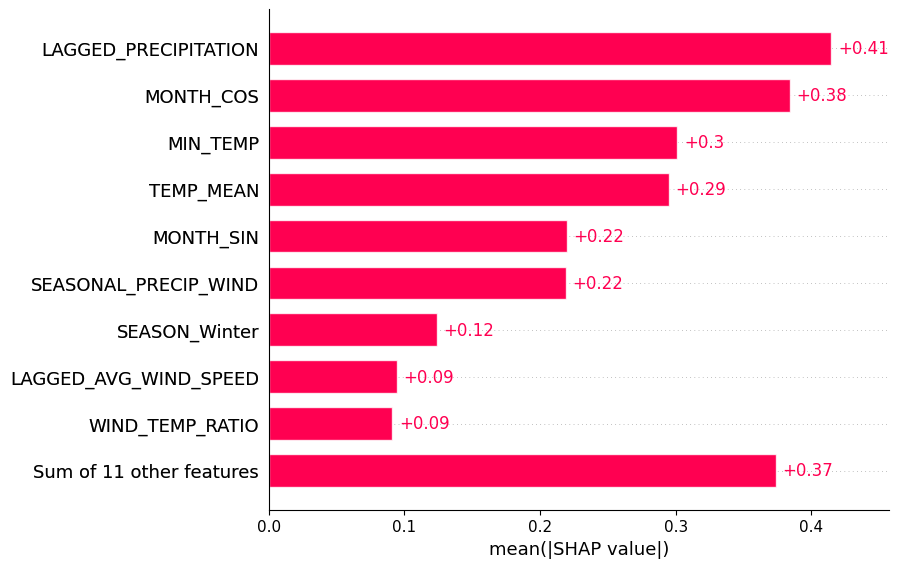

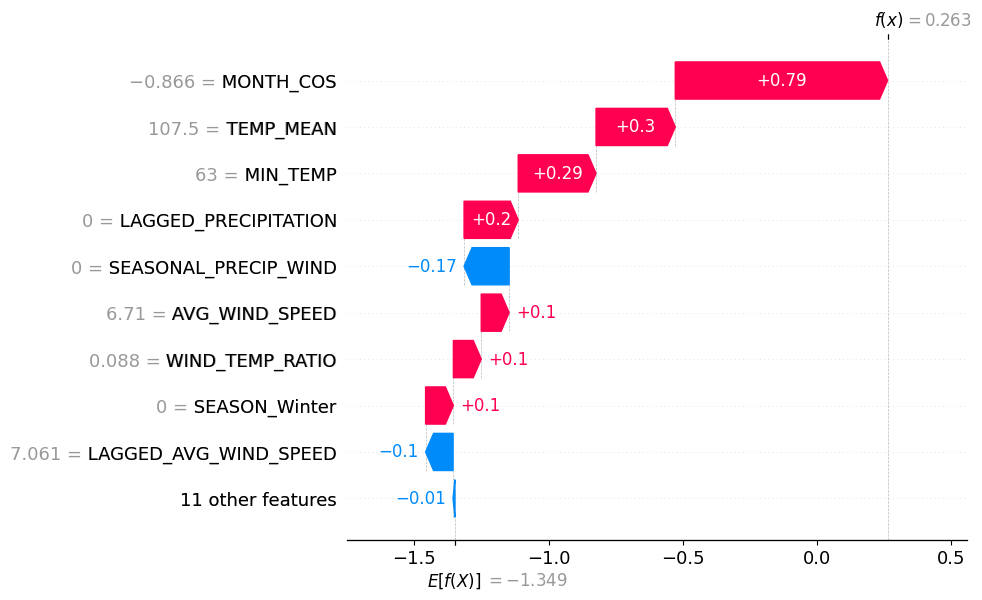

In [21]:
import shap
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)

# Summary plot：看整體特徵重要性
shap.summary_plot(shap_values, X_test)

# 2️⃣ Feature importance 排名（平均貢獻度）
shap.plots.bar(shap_values)

# 3️⃣ 解釋單一筆資料（local解釋）
shap.plots.waterfall(shap_values[0])


### 模型評估：

- 精度 (Precision)：對於類別 0（負樣本），精度達到 0.84，對於類別 1（正樣本），精度為 0.70。這意味著模型在預測正樣本時可能有一些錯誤，可能會錯誤地標記一些負樣本為正樣本。

- 召回率 (Recall)：對於類別 0，召回率為 0.87，這是比較好的，說明模型能夠正確標記大部分的負樣本。然而，對於類別 1，召回率是 0.64，意味著有相當一部分的正樣本未被成功預測出來，這可能是過擬合的跡象或者模型對某些特徵不夠敏感。

- F1-score：在平衡精度和召回率後，類別 0 的 F1-score 是 0.85，而類別 1 的 F1-score 是 0.67，這表明模型對於類別 0 的預測表現要好於類別 1。

In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV 

In [23]:
# 2) Tuned XGBoost via RandomizedSearchCV
param_dist_xgb = {
    'alpha' : [0.0, 0.1, 0.5, 1.0, 2.0],  # L1 正則化強度，通常設為較小的正值
    'lambda_' : [0.0, 0.1, 0.5, 1.0, 2.0],  # L2 正則化強度，默認為1
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5],
    'min_child_weight': [1, 3, 5]
}

xgb_search = RandomizedSearchCV(
    estimator=XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    param_distributions=param_dist_xgb,
    n_iter=30,
    cv=5,
    scoring='roc_auc',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit search
xgb_search.fit(X_train, y_train)

# Get the best model
best_xgb = xgb_search.best_estimator_

# Predict with best model
y_pred_best_xgb = best_xgb.predict(X_test)
y_proba_best_xgb = best_xgb.predict_proba(X_test)[:, 1]

Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\ygz08\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [11:38:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "lambda_", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [24]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
print("--- Best XGBoost (Tuned) ---")
print("Best Parameters:", xgb_search.best_params_)
print("Classification Report:\n", classification_report(y_test, y_pred_best_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best_xgb))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_best_xgb))

--- Best XGBoost (Tuned) ---
Best Parameters: {'subsample': 0.8, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.01, 'lambda_': 1.0, 'gamma': 0.2, 'colsample_bytree': 0.6, 'alpha': 0.1}
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.85      0.84      3047
           1       0.66      0.63      0.65      1450

    accuracy                           0.78      4497
   macro avg       0.75      0.74      0.74      4497
weighted avg       0.78      0.78      0.78      4497

Confusion Matrix:
 [[2577  470]
 [ 531  919]]
ROC AUC Score: 0.83236909113543


### 結果分析：
- 精度 (Precision)：

    - 類別 0（沒有野火發生） precision: 0.84，這表明大部分被預測為沒有野火的樣本確實是沒有野火。

    - 類別 1（有野火發生） precision: 0.70，這表示模型對於有野火的預測並不如對無野火的預測準確。

- 召回率 (Recall)：

    - 類別 0 recall: 0.87，這說明模型能夠有效地捕捉到大多數沒有野火的樣本。

    - 類別 1 recall: 0.65，這表示對有野火的預測仍然有改進的空間，可能是因為過擬合或特徵選擇不夠充分。

- F1 分數 (F1-Score)：

    - 類別 0 F1-Score: 0.85，這說明對類別 0 的預測效果良好。

    - 類別 1 F1-Score: 0.67，這顯示對類別 1 的預測仍然有提升的空間，可能需要更多針對該類別的特徵或優化。

- ROC AUC Score：0.8619，這是衡量模型區分能力的指標，值較高，說明模型對區分兩類有較好的能力。

<hr>

## DNN

<h5>

- Keras Sequential 架構建構的全連接深度神經網路（DNN），適用於二元分類任務。

- 包含三層 ReLU 隱藏層（256-512-128），每層均使用 L2 正則化與 Dropout(0.3) 以減少過擬合。

- 輸入經過 Batch Normalization 處理，輸出為 sigmoid 函數對應的機率值。

</h5>

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras import regularizers

In [26]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

# 查看結果
print("Class Weights:", class_weight_dict)

Class Weights: {np.int64(0): np.float64(0.7525824964131994), np.int64(1): np.float64(1.4897756319227493)}


In [27]:
run_name = Tryname + '_DNN'

with mlflow.start_run(run_name=run_name):#mlflow
    mlflow.tensorflow.autolog()#mlflow    

    n_input = X_train.shape[1]

    model = Sequential()
    model.add(BatchNormalization())
    model.add(Dense(256, input_shape=(n_input,), activation='relu',
                    kernel_regularizer=regularizers.l2(0.001)))  # L2
    model.add(Dropout(0.3))  # 增加 Dropout
    model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))


    # 模型optimizer 和 learning rate


    initial_lr = 0.001
    from tensorflow.keras.optimizers import schedules
    lr_schedule = schedules.ExponentialDecay(
        initial_learning_rate=initial_lr,
        decay_steps=100000,
        decay_rate=0.96,
        staircase=True)
    from tensorflow.keras.optimizers import Adam
    optimizer = Adam(learning_rate=lr_schedule)
    model.summary()

    mlflow.log_param("loss", 'bce') #mlflow
    model.compile(loss='bce', optimizer=optimizer, metrics=['acc', 'Recall', 'Precision'])

    # EarlyStopping: 根據 val_loss 停止訓練
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
    # ModelCheckpoint: 儲存最佳模型
    from tensorflow.keras.callbacks import ModelCheckpoint
    checkpoint = ModelCheckpoint('./models_temp/DNN_best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

    if Weight_Balance == 1:
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=128, verbose=1, class_weight=class_weight_dict)
    else:
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=128, verbose=1)

    train_loss, train_acc, train_recall, train_precision = model.evaluate(X_train, y_train, verbose=0)
    test_loss, test_acc, test_recall, test_precision = model.evaluate(X_test, y_test, verbose=0)
    mlflow.log_metric("Train score", train_acc)#mlflow
    mlflow.log_metric("Test score", test_acc)#mlflow
    #註冊模型
    run_id = mlflow.active_run().info.run_id#mlflow
    result = mlflow.register_model(
        model_uri=f"runs:/{run_id}/model",  # 你要用 mlflow.log_model 存的位置
        name="DNN-model"              # 註冊後的 model name
    )
    #confusion matrix
    from sklearn.metrics import classification_report
    y_pred = model.predict(X_test)
    y_pred_class = (y_pred > 0.5).astype(int) 
    report_dict = classification_report(y_test, y_pred_class, output_dict=True)
    print(report_dict)
    for label, metrics in report_dict.items():
        if isinstance(metrics, dict):  # 各分類或 avg 區段
            for metric_name, value in metrics.items():
                metric_key = f"{label}_{metric_name}".replace(" ", "_")  # 去除空格
                mlflow.log_metric(metric_key, value)
        elif isinstance(metrics, (int, float)):  # accuracy 是 float
            mlflow.log_metric(label, metrics)
    
    model.evaluate(X_test, y_test)

C:\Users\ygz08\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

2025/05/05 11:38:24 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: Sequential model 'sequential' has no defined input shape yet.
2025/05/05 11:38:24 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'pandas.core.frame.DataFrame'>. Dataset logging skipped.
2025/05/05 11:38:24 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'DataFrame' object has no attribute 'flatten'


Epoch 1/100
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.6057 - Recall: 0.5153 - acc: 0.7227 - loss: 1.0350

82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - Precision: 0.6068 - Recall: 0.5174 - acc: 0.7235 - loss: 1.0323 - val_Precision: 0.3277 - val_Recall: 1.0000 - val_acc: 0.3384 - val_loss: 1.6004
Epoch 2/100
77/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.6502 - Recall: 0.6245 - acc: 0.7630 - loss: 0.7410

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6510 - Recall: 0.6256 - acc: 0.7633 - loss: 0.7381 - val_Precision: 0.5117 - val_Recall: 0.8752 - val_acc: 0.6905 - val_loss: 0.7252
Epoch 3/100
73/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Precision: 0.6648 - Recall: 0.6336 - acc: 0.7655 - loss: 0.6299

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6653 - Recall: 0.6342 - acc: 0.7664 - loss: 0.6266 - val_Precision: 0.5695 - val_Recall: 0.7993 - val_acc: 0.7405 - val_loss: 0.5985
Epoch 4/100
73/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Precision: 0.6578 - Recall: 0.6537 - acc: 0.7768 - loss: 0.5537

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6582 - Recall: 0.6537 - acc: 0.7761 - loss: 0.5531 - val_Precision: 0.6187 - val_Recall: 0.7386 - val_acc: 0.7690 - val_loss: 0.5336
Epoch 5/100
80/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.6631 - Recall: 0.6570 - acc: 0.7738 - loss: 0.5293

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6631 - Recall: 0.6569 - acc: 0.7738 - loss: 0.5290 - val_Precision: 0.6514 - val_Recall: 0.6690 - val_acc: 0.7779 - val_loss: 0.5059
Epoch 6/100
77/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.6665 - Recall: 0.6691 - acc: 0.7782 - loss: 0.5038

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6660 - Recall: 0.6684 - acc: 0.7778 - loss: 0.5042 - val_Precision: 0.6652 - val_Recall: 0.6152 - val_acc: 0.7761 - val_loss: 0.4975
Epoch 7/100
74/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Precision: 0.6678 - Recall: 0.6369 - acc: 0.7744 - loss: 0.4974

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6672 - Recall: 0.6388 - acc: 0.7742 - loss: 0.4974 - val_Precision: 0.6485 - val_Recall: 0.6717 - val_acc: 0.7767 - val_loss: 0.4925
Epoch 8/100
75/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.6581 - Recall: 0.6433 - acc: 0.7746 - loss: 0.4944

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6591 - Recall: 0.6441 - acc: 0.7746 - loss: 0.4943 - val_Precision: 0.6529 - val_Recall: 0.6759 - val_acc: 0.7796 - val_loss: 0.4853
Epoch 9/100
79/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.6745 - Recall: 0.6546 - acc: 0.7764 - loss: 0.4847

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6741 - Recall: 0.6545 - acc: 0.7762 - loss: 0.4848 - val_Precision: 0.6431 - val_Recall: 0.7083 - val_acc: 0.7792 - val_loss: 0.4838
Epoch 10/100
79/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.6536 - Recall: 0.6594 - acc: 0.7678 - loss: 0.4931

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6540 - Recall: 0.6590 - acc: 0.7680 - loss: 0.4928 - val_Precision: 0.6529 - val_Recall: 0.6772 - val_acc: 0.7799 - val_loss: 0.4803
Epoch 11/100
78/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.6556 - Recall: 0.6726 - acc: 0.7689 - loss: 0.4866

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6556 - Recall: 0.6719 - acc: 0.7690 - loss: 0.4867 - val_Precision: 0.6751 - val_Recall: 0.5890 - val_acc: 0.7761 - val_loss: 0.4795
Epoch 12/100
74/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Precision: 0.6647 - Recall: 0.6292 - acc: 0.7680 - loss: 0.4869

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6643 - Recall: 0.6315 - acc: 0.7683 - loss: 0.4868 - val_Precision: 0.6719 - val_Recall: 0.5862 - val_acc: 0.7743 - val_loss: 0.4777
Epoch 13/100
78/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.6610 - Recall: 0.6480 - acc: 0.7673 - loss: 0.4910

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6611 - Recall: 0.6487 - acc: 0.7676 - loss: 0.4908 - val_Precision: 0.6533 - val_Recall: 0.6641 - val_acc: 0.7781 - val_loss: 0.4775
Epoch 14/100
73/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Precision: 0.6590 - Recall: 0.6245 - acc: 0.7674 - loss: 0.4935

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6599 - Recall: 0.6272 - acc: 0.7682 - loss: 0.4921 - val_Precision: 0.6448 - val_Recall: 0.7048 - val_acc: 0.7796 - val_loss: 0.4769
Epoch 15/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6533 - Recall: 0.6637 - acc: 0.7708 - loss: 0.4852 - val_Precision: 0.6512 - val_Recall: 0.6772 - val_acc: 0.7790 - val_loss: 0.4779
Epoch 16/100
78/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.6594 - Recall: 0.6543 - acc: 0.7699 - loss: 0.4863

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.6592 - Recall: 0.6547 - acc: 0.7699 - loss: 0.4861 - val_Precision: 0.6750 - val_Recall: 0.5972 - val_acc: 0.7774 - val_loss: 0.4740
Epoch 17/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6639 - Recall: 0.6342 - acc: 0.7735 - loss: 0.4837 - val_Precision: 0.6492 - val_Recall: 0.6855 - val_acc: 0.7792 - val_loss: 0.4767
Epoch 18/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6735 - Recall: 0.6768 - acc: 0.7814 - loss: 0.4725 - val_Precision: 0.6745 - val_Recall: 0.5917 - val_acc: 0.7763 - val_loss: 0.4752
Epoch 19/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6799 - Recall: 0.6436 - acc: 0.7817 - loss: 0.4752 - val_Precision: 0.6389 - val_Recall: 0.6993 - val_acc: 0.7756 - val_loss: 0.4770
Epoch 20/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6720 - Recall: 0.6781 - acc: 0.7803 - loss: 0.4725 - val_Precision: 0.6657 - val_Recall: 0.6262 - val_acc: 0.7781 - val_loss: 0.4753
Epoch 21/100


82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6533 - Recall: 0.6747 - acc: 0.7616 - loss: 0.4964 - val_Precision: 0.6774 - val_Recall: 0.5966 - val_acc: 0.7783 - val_loss: 0.4732
Epoch 23/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6751 - Recall: 0.6650 - acc: 0.7790 - loss: 0.4745 - val_Precision: 0.6546 - val_Recall: 0.6759 - val_acc: 0.7805 - val_loss: 0.4740
Epoch 24/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6718 - Recall: 0.6698 - acc: 0.7791 - loss: 0.4709 - val_Precision: 0.6465 - val_Recall: 0.6848 - val_acc: 0.7776 - val_loss: 0.4747
Epoch 25/100
75/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.6851 - Recall: 0.6669 - acc: 0.7799 - loss: 0.4792

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6832 - Recall: 0.6656 - acc: 0.7792 - loss: 0.4792 - val_Precision: 0.6679 - val_Recall: 0.6269 - val_acc: 0.7792 - val_loss: 0.4723
Epoch 26/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6579 - Recall: 0.6386 - acc: 0.7697 - loss: 0.4792 - val_Precision: 0.6642 - val_Recall: 0.6193 - val_acc: 0.7763 - val_loss: 0.4774
Epoch 27/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6785 - Recall: 0.6409 - acc: 0.7787 - loss: 0.4718 - val_Precision: 0.6535 - val_Recall: 0.6752 - val_acc: 0.7799 - val_loss: 0.4759
Epoch 28/100
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.6591 - Recall: 0.6597 - acc: 0.7748 - loss: 0.4790

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6592 - Recall: 0.6597 - acc: 0.7748 - loss: 0.4791 - val_Precision: 0.6664 - val_Recall: 0.6159 - val_acc: 0.7767 - val_loss: 0.4713
Epoch 29/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6717 - Recall: 0.6501 - acc: 0.7746 - loss: 0.4780 - val_Precision: 0.6684 - val_Recall: 0.6159 - val_acc: 0.7776 - val_loss: 0.4744
Epoch 30/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6654 - Recall: 0.6514 - acc: 0.7704 - loss: 0.4782 - val_Precision: 0.6702 - val_Recall: 0.6138 - val_acc: 0.7781 - val_loss: 0.4720
Epoch 31/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6709 - Recall: 0.6507 - acc: 0.7773 - loss: 0.4695 - val_Precision: 0.6590 - val_Recall: 0.6545 - val_acc: 0.7794 - val_loss: 0.4719
Epoch 32/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6572 - Recall: 0.6539 - acc: 0.7725 - loss: 0.4744 - val_Precision: 0.6652 - val_Recall: 0.6455 - val_acc: 0.7810 - val_loss: 0.4718
Epoch 33/100


82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6653 - Recall: 0.6479 - acc: 0.7732 - loss: 0.4789 - val_Precision: 0.6643 - val_Recall: 0.6483 - val_acc: 0.7810 - val_loss: 0.4708
Epoch 37/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6627 - Recall: 0.6426 - acc: 0.7721 - loss: 0.4778 - val_Precision: 0.6511 - val_Recall: 0.6717 - val_acc: 0.7781 - val_loss: 0.4728
Epoch 38/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6772 - Recall: 0.6621 - acc: 0.7755 - loss: 0.4789 - val_Precision: 0.6607 - val_Recall: 0.6393 - val_acc: 0.7779 - val_loss: 0.4754
Epoch 39/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6743 - Recall: 0.6729 - acc: 0.7805 - loss: 0.4754 - val_Precision: 0.6633 - val_Recall: 0.6372 - val_acc: 0.7787 - val_loss: 0.4722
Epoch 40/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6619 - Recall: 0.6466 - acc: 0.7729 - loss: 0.4755 - val_Precision: 0.6479 - val_Recall: 0.6903 - val_acc: 0.7792 - val_loss: 0.4742
Epoch 41/100


82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6678 - Recall: 0.6670 - acc: 0.7741 - loss: 0.4742 - val_Precision: 0.6616 - val_Recall: 0.6352 - val_acc: 0.7776 - val_loss: 0.4701
Epoch 47/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6779 - Recall: 0.6600 - acc: 0.7794 - loss: 0.4706 - val_Precision: 0.6613 - val_Recall: 0.6462 - val_acc: 0.7792 - val_loss: 0.4707
Epoch 48/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6682 - Recall: 0.6594 - acc: 0.7834 - loss: 0.4676 - val_Precision: 0.6466 - val_Recall: 0.7041 - val_acc: 0.7805 - val_loss: 0.4742
Epoch 49/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6646 - Recall: 0.6700 - acc: 0.7776 - loss: 0.4714 - val_Precision: 0.6489 - val_Recall: 0.6897 - val_acc: 0.7796 - val_loss: 0.4738
Epoch 50/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6629 - Recall: 0.6426 - acc: 0.7678 - loss: 0.4878 - val_Precision: 0.6454 - val_Recall: 0.6828 - val_acc: 0.7767 - val_loss: 0.4740
Epoch 51/100


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - Precision: 0.6570 - Recall: 0.6543 - acc: 0.7722 - loss: 0.4755 - val_Precision: 0.6701 - val_Recall: 0.6234 - val_acc: 0.7796 - val_loss: 0.4697
Epoch 64/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6595 - Recall: 0.6598 - acc: 0.7717 - loss: 0.4743 - val_Precision: 0.6650 - val_Recall: 0.6338 - val_acc: 0.7790 - val_loss: 0.4723
Epoch 65/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6676 - Recall: 0.6379 - acc: 0.7723 - loss: 0.4751 - val_Precision: 0.6551 - val_Recall: 0.6641 - val_acc: 0.7790 - val_loss: 0.4713
Epoch 66/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6668 - Recall: 0.6675 - acc: 0.7747 - loss: 0.4756 - val_Precision: 0.6576 - val_Recall: 0.6503 - val_acc: 0.7781 - val_loss: 0.4705
Epoch 67/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6717 - Recall: 0.6647 - acc: 0.7713 - loss: 0.4880 - val_Precision: 0.6472 - val_Recall: 0.6897 - val_acc: 0.7787 - val_loss: 0.4725
Epoch 68/100


2025/05/05 11:39:12 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: Cannot log input example or model signature for input with type <class 'pandas.core.frame.DataFrame'>. TensorFlow Keras autologging can only log input examples and model signatures for the following input types: numpy.ndarray, dict[string -> numpy.ndarray], tensorflow.keras.utils.Sequence, and tensorflow.data.Dataset (TensorFlow >= 2.1.0 required)
2025/05/05 11:39:12 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/05/05 11:39:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'DNN-model' already exists. Creating a new v

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
{'0': {'precision': 0.8431568431568431, 'recall': 0.8309812930751559, 'f1-score': 0.8370247933884297, 'support': 3047.0}, '1': {'precision': 0.6552878179384204, 'recall': 0.6751724137931034, 'f1-score': 0.6650815217391305, 'support': 1450.0}, 'accuracy': 0.7807427173671336, 'macro avg': {'precision': 0.7492223305476318, 'recall': 0.7530768534341297, 'f1-score': 0.7510531575637801, 'support': 4497.0}, 'weighted avg': {'precision': 0.7825808843917302, 'recall': 0.7807427173671336, 'f1-score': 0.7815838896989737, 'support': 4497.0}}
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Precision: 0.6540 - Recall: 0.6477 - acc: 0.7739 - loss: 0.4789


### 結果分析：
- Recall 提升了不少

    - Recall（靈敏度）高達 ~82%，這對於偵測火災（正類）是好事，表示較少漏判火災發生。

- Precision 稍低，但在接受範圍內

    - Precision 約 57%，代表有一些假陽性，但 Recall 更重要時（例如防災應用），這是可以接受的 trade-off。

- class_weight 有明顯效果




<hr>

## Attention mechanism

<h5>

- 本模型為結合注意力機制的深度神經網路，設計用於處理二元分類任務。

- 模型架構包含全連接層與多頭注意力層，強化特徵間的關聯學習能力。

- 輸入特徵先經 Batch Normalization 與 Dense 處理後，透過 Reshape 轉為序列格式，接入 Multi-Head Attention 抽取關鍵特徵。

</h5>


In [28]:
X = df.drop(['FIRE_START_DAY'], axis=1)
y = df['FIRE_START_DAY']
X = X.fillna(X.median())
assert X.isna().sum().sum() == 0, "There are still missing values in the dataset."
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [29]:
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, MultiHeadAttention, Flatten, GlobalAveragePooling1D, Reshape
from tensorflow.keras.models import Model

run_name = Tryname + '_AttentionMechanisim'

with mlflow.start_run(run_name=run_name):#mlflow
    mlflow.tensorflow.autolog()#mlflow    
    n_input = X_train.shape[1]
    # Model
    # 定義模型
    input_layer = Input(shape=(n_input,))
    x = BatchNormalization()(input_layer)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    # Reshape 輸入，以便進行注意力機制（將它變成三維張量）
    x = Reshape((1, 128))(x)  # 假設每個樣本有 128 個特徵，這樣就會有 1 個時間步
    # 添加多頭注意力層
    x_attention = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)  # query, key 和 value 都是 x
    x_attention = Dropout(0.1)(x_attention)
    # 將注意力層的輸出展平
    x_flattened = Flatten()(x_attention)
    # 經過展平後的處理
    x = Dense(128, activation='relu')(x_flattened)
    x = Dropout(0.1)(x)
    output = Dense(1, activation='sigmoid')(x)


    # Model
    model = Model(inputs=input_layer, outputs=output)
    model.summary()
    # 模型optimizer 和 learning rate
    initial_lr = 0.001
    from tensorflow.keras.optimizers import schedules
    lr_schedule = schedules.ExponentialDecay(
        initial_learning_rate=initial_lr,
        decay_steps=100000,
        decay_rate=0.96,
        staircase=True)
    from tensorflow.keras.optimizers import Adam
    optimizer = Adam(learning_rate=lr_schedule)

    model.compile(loss='bce', optimizer=optimizer, metrics=['acc', 'Recall', 'Precision'])
    # EarlyStopping: 根據 val_loss 停止訓練
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
    # ModelCheckpoint: 儲存最佳模型
    checkpoint = ModelCheckpoint('./models_temp/attention_best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
    if Weight_Balance == 1:
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=128, verbose=1, callbacks=[early_stop, checkpoint], class_weight=class_weight_dict)
    else:
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=128, verbose=1, callbacks=[early_stop, checkpoint])
    train_loss, train_acc, train_recall, train_precision = model.evaluate(X_train, y_train, verbose=0)
    test_loss, test_acc, test_recall, test_precision = model.evaluate(X_test, y_test, verbose=0)
    mlflow.log_metric("Train score", train_acc)#mlflow
    mlflow.log_metric("Test score", test_acc)#mlflow
    #註冊模型
    run_id = mlflow.active_run().info.run_id#mlflow
    result = mlflow.register_model(
        model_uri=f"runs:/{run_id}/model",  # 你要用 mlflow.log_model 存的位置
        name="attention-model"              # 註冊後的 model name
    )
    
    #confusion matrix
    from sklearn.metrics import classification_report
    y_pred = model.predict(X_test)
    y_pred_class = (y_pred > 0.5).astype(int) 
    report_dict = classification_report(y_test, y_pred_class, output_dict=True)
    print(report_dict)
    for label, metrics in report_dict.items():
        if isinstance(metrics, dict):  # 各分類或 avg 區段
            for metric_name, value in metrics.items():
                try:
                    label_key = str(int(label))  # 嘗試轉成數字型的 label
                except ValueError:
                    label_key = label.replace(" ", "_")  # 否則保留原樣但移除空格

                metric_key = f"{label_key}_{metric_name}".replace(" ", "_")
                mlflow.log_metric(metric_key, value)
        elif isinstance(metrics, (int, float)):  # accuracy 是 float
            mlflow.log_metric(label, metrics)


    # 評估模型
    model.evaluate(X_test, y_test)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20)        │         80 │ input_layer_1[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │      2,688 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 128)    │          0 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 128)    │     66,048 │ reshape[0][0],    │
│ (MultiHeadAttentio… │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 1, 128)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 128)       │          0 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     16,512 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │        129 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 85,457 (333.82 KB)

 Trainable params: 85,417 (333.66 KB)

 Non-trainable params: 40 (160.00 B)

2025/05/05 11:39:20 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'pandas.core.frame.DataFrame'>. Dataset logging skipped.
2025/05/05 11:39:20 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'DataFrame' object has no attribute 'flatten'


Epoch 1/100
78/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6142 - Recall: 0.5748 - acc: 0.7328 - loss: 0.5305
Epoch 1: val_loss improved from inf to 0.84277, saving model to ./models_temp/attention_best_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - Precision: 0.6163 - Recall: 0.5777 - acc: 0.7345 - loss: 0.5284 - val_Precision: 0.3667 - val_Recall: 0.9834 - val_acc: 0.4470 - val_loss: 0.8428
Epoch 2/100
77/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6518 - Recall: 0.6413 - acc: 0.7642 - loss: 0.4856
Epoch 2: val_loss improved from 0.84277 to 0.56737, saving model to ./models_temp/attention_best_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.6525 - Recall: 0.6416 - acc: 0.7647 - loss: 0.4848 - val_Precision: 0.5014 - val_Recall: 0.8890 - val_acc: 0.6791 - val_loss: 0.5674
Epoch 3/100
75/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6663 - Recall: 0.6632 - acc: 0.7734 - loss: 0.4671
Epoch 3: val_loss improved from 0.56737 to 0.51028, saving model to ./models_temp/attention_best_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.6663 - Recall: 0.6615 - acc: 0.7733 - loss: 0.4674 - val_Precision: 0.5661 - val_Recall: 0.8097 - val_acc: 0.7385 - val_loss: 0.5103
Epoch 4/100
78/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6692 - Recall: 0.6595 - acc: 0.7769 - loss: 0.4690
Epoch 4: val_loss improved from 0.51028 to 0.47351, saving model to ./models_temp/attention_best_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.6694 - Recall: 0.6585 - acc: 0.7768 - loss: 0.4693 - val_Precision: 0.6312 - val_Recall: 0.7200 - val_acc: 0.7741 - val_loss: 0.4735
Epoch 5/100
79/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6621 - Recall: 0.6501 - acc: 0.7643 - loss: 0.4764
Epoch 5: val_loss did not improve from 0.47351
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Precision: 0.6618 - Recall: 0.6501 - acc: 0.7644 - loss: 0.4762 - val_Precision: 0.6505 - val_Recall: 0.6648 - val_acc: 0.7767 - val_loss: 0.4745
Epoch 6/100
76/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6618 - Recall: 0.6352 - acc: 0.7708 - loss: 0.4730
Epoch 6: val_loss improved from 0.47351 to 0.46890, saving model to ./models_temp/attention_best_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.6622 - Recall: 0.6363 - acc: 0.7710 - loss: 0.4730 - val_Precision: 0.6637 - val_Recall: 0.6248 - val_acc: 0.7770 - val_loss: 0.4689
Epoch 7/100
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6708 - Recall: 0.6387 - acc: 0.7731 - loss: 0.4707
Epoch 7: val_loss did not improve from 0.46890
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.6707 - Recall: 0.6389 - acc: 0.7731 - loss: 0.4708 - val_Precision: 0.6477 - val_Recall: 0.6910 - val_acc: 0.7792 - val_loss: 0.4701
Epoch 8/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6640 - Recall: 0.6524 - acc: 0.7729 - loss: 0.4679
Epoch 8: val_loss improved from 0.46890 to 0.46693, saving model to ./models_temp/attention_best_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - Precision: 0.6641 - Recall: 0.6523 - acc: 0.7729 - loss: 0.4679 - val_Precision: 0.6636 - val_Recall: 0.6434 - val_acc: 0.7799 - val_loss: 0.4669
Epoch 9/100
79/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6797 - Recall: 0.6832 - acc: 0.7857 - loss: 0.4577
Epoch 9: val_loss did not improve from 0.46693
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Precision: 0.6793 - Recall: 0.6821 - acc: 0.7853 - loss: 0.4581 - val_Precision: 0.6641 - val_Recall: 0.6503 - val_acc: 0.7812 - val_loss: 0.4692
Epoch 10/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6867 - Recall: 0.6487 - acc: 0.7809 - loss: 0.4630
Epoch 10: val_loss did not improve from 0.46693
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.6865 - Recall: 0.6487 - acc: 0.7809 - loss: 0.4631 - val_Precision: 0.6662 - val_Recall: 0.6331 - val_acc: 0.7794 - val_loss: 0.4673
Epoch 11/100
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6633 - Recall: 0.6338 - acc: 0.7714 - loss

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - Precision: 0.6634 - Recall: 0.6340 - acc: 0.7714 - loss: 0.4672 - val_Precision: 0.6798 - val_Recall: 0.5814 - val_acc: 0.7767 - val_loss: 0.4669
Epoch 12/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6697 - Recall: 0.6451 - acc: 0.7691 - loss: 0.4775
Epoch 12: val_loss did not improve from 0.46688
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Precision: 0.6697 - Recall: 0.6451 - acc: 0.7691 - loss: 0.4774 - val_Precision: 0.6763 - val_Recall: 0.5462 - val_acc: 0.7694 - val_loss: 0.4725
Epoch 13/100
74/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6791 - Recall: 0.6509 - acc: 0.7757 - loss: 0.4738
Epoch 13: val_loss did not improve from 0.46688
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - Precision: 0.6783 - Recall: 0.6522 - acc: 0.7758 - loss: 0.4734 - val_Precision: 0.6803 - val_Recall: 0.5752 - val_acc: 0.7759 - val_loss: 0.4704
Epoch 14/100
79/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6900 - Recall: 0.6430 - acc: 0.7814 - lo

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - Precision: 0.6659 - Recall: 0.6588 - acc: 0.7752 - loss: 0.4678 - val_Precision: 0.6569 - val_Recall: 0.6669 - val_acc: 0.7803 - val_loss: 0.4653
Epoch 16/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6569 - Recall: 0.6665 - acc: 0.7702 - loss: 0.4664
Epoch 16: val_loss did not improve from 0.46535
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.6570 - Recall: 0.6665 - acc: 0.7702 - loss: 0.4664 - val_Precision: 0.6672 - val_Recall: 0.6124 - val_acc: 0.7765 - val_loss: 0.4671
Epoch 17/100
77/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6740 - Recall: 0.6459 - acc: 0.7742 - loss: 0.4685
Epoch 17: val_loss did not improve from 0.46535
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Precision: 0.6737 - Recall: 0.6458 - acc: 0.7742 - loss: 0.4683 - val_Precision: 0.6600 - val_Recall: 0.6572 - val_acc: 0.7803 - val_loss: 0.4658
Epoch 18/100
78/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6740 - Recall: 0.6516 - acc: 0.7789 - lo

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.6701 - Recall: 0.6619 - acc: 0.7746 - loss: 0.4666 - val_Precision: 0.6744 - val_Recall: 0.6041 - val_acc: 0.7783 - val_loss: 0.4647
Epoch 23/100
75/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6886 - Recall: 0.6545 - acc: 0.7787 - loss: 0.4661
Epoch 23: val_loss did not improve from 0.46471
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Precision: 0.6870 - Recall: 0.6544 - acc: 0.7785 - loss: 0.4660 - val_Precision: 0.6649 - val_Recall: 0.6214 - val_acc: 0.7770 - val_loss: 0.4666
Epoch 24/100
76/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6664 - Recall: 0.6326 - acc: 0.7726 - loss: 0.4644
Epoch 24: val_loss did not improve from 0.46471
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.6673 - Recall: 0.6336 - acc: 0.7731 - loss: 0.4643 - val_Precision: 0.6442 - val_Recall: 0.6855 - val_acc: 0.7765 - val_loss: 0.4695
Epoch 25/100
74/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6644 - Recall: 0.6842 - acc: 0.7824 - lo

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.6755 - Recall: 0.6645 - acc: 0.7710 - loss: 0.4716 - val_Precision: 0.6638 - val_Recall: 0.6483 - val_acc: 0.7807 - val_loss: 0.4646
Epoch 27/100
77/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6739 - Recall: 0.6510 - acc: 0.7769 - loss: 0.4644
Epoch 27: val_loss did not improve from 0.46455
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Precision: 0.6736 - Recall: 0.6513 - acc: 0.7768 - loss: 0.4645 - val_Precision: 0.6645 - val_Recall: 0.6338 - val_acc: 0.7787 - val_loss: 0.4649
Epoch 28/100
77/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6653 - Recall: 0.6513 - acc: 0.7777 - loss: 0.4587
Epoch 28: val_loss did not improve from 0.46455
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Precision: 0.6656 - Recall: 0.6514 - acc: 0.7775 - loss: 0.4591 - val_Precision: 0.6676 - val_Recall: 0.6262 - val_acc: 0.7790 - val_loss: 0.4673
Epoch 29/100
74/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6636 - Recall: 0.6411 - acc: 0.7714 - lo

2025/05/05 11:39:46 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: Cannot log input example or model signature for input with type <class 'pandas.core.frame.DataFrame'>. TensorFlow Keras autologging can only log input examples and model signatures for the following input types: numpy.ndarray, dict[string -> numpy.ndarray], tensorflow.keras.utils.Sequence, and tensorflow.data.Dataset (TensorFlow >= 2.1.0 required)
2025/05/05 11:39:46 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/05/05 11:39:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'attention-model' already exists. Creating a

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
{'0': {'precision': 0.8344693281402142, 'recall': 0.8437807679684936, 'f1-score': 0.8390992167101827, 'support': 3047.0}, '1': {'precision': 0.6638418079096046, 'recall': 0.6482758620689655, 'f1-score': 0.6559665038381018, 'support': 1450.0}, 'accuracy': 0.7807427173671336, 'macro avg': {'precision': 0.7491555680249093, 'recall': 0.7460283150187295, 'f1-score': 0.7475328602741422, 'support': 4497.0}, 'weighted avg': {'precision': 0.7794526716282321, 'recall': 0.7807427173671336, 'f1-score': 0.7800504211432454, 'support': 4497.0}}
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Precision: 0.6628 - Recall: 0.6262 - acc: 0.7748 - loss: 0.4744


<hr>

## LSTM

<h5>

- 本模型採用雙層 LSTM 結構，設計用於處理序列型輸入的二元分類任務。

- 模型包含兩層 LSTM（64 與 32 單元）搭配 Dropout 與 L2 正則化，有效防止過擬合。

- 輸入為三維時間序列資料，經 LSTM 擷取時序特徵後，輸出 sigmoid 機率作為預測結果。

</h5>

In [30]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [31]:
#準備序列數據 (Prepare sequences)
LSdf = LSdf.drop(columns=['DATE', 'DAY_OF_YEAR']) #刪除不必要的欄位
df_seq = LSdf.sort_values(by=['YEAR', 'MONTH']).reset_index(drop=True)
X_all = df_seq.drop(columns=['YEAR', 'MONTH', 'FIRE_START_DAY'])
X_all = X_all.fillna(X.median())
assert X_all.isna().sum().sum() == 0, "There are still missing values in the dataset."
y_all = df_seq['FIRE_START_DAY']
def create_sequences(X, y, time_steps=12): #時間步長為12
    Xs, ys = [], []
    for i in range(len(X) - time_steps): #(11980, 12, 17) 
        Xs.append(X[i:(i + time_steps)])#(11980, 12, 17)
        ys.append(y[i + time_steps])#(11980,)
    #X[i:(i + time_steps)] 會取出從 i 到 i+time_steps 的資料，這樣就能夠形成一個時間序列的樣本。
    return np.array(Xs), np.array(ys)

#對於每個樣本，Xs 會包含過去12個時刻的特徵，而 ys 會包含12個時間步長後的目標變數。
time_steps  = 12
X_seq, y_seq = create_sequences(X_all, y_all, time_steps=time_steps)

#訓練/測試集切分 (Train/test split)
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq,
    test_size=0.2,
    random_state=42,
    stratify=y_seq
)

In [32]:
X_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14988 entries, 0 to 14987
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   PRECIPITATION             14988 non-null  float64
 1   MAX_TEMP                  14988 non-null  float64
 2   MIN_TEMP                  14988 non-null  float64
 3   AVG_WIND_SPEED            14988 non-null  float64
 4   TEMP_RANGE                14988 non-null  float64
 5   WIND_TEMP_RATIO           14988 non-null  float64
 6   LAGGED_PRECIPITATION      14988 non-null  float64
 7   LAGGED_AVG_WIND_SPEED     14988 non-null  float64
 8   MONTH_SIN                 14988 non-null  float64
 9   MONTH_COS                 14988 non-null  float64
 10  IS_RAINING                14988 non-null  int64  
 11  TEMP_MEAN                 14988 non-null  float64
 12  PRECIPITATION_WIND_RATIO  14988 non-null  float64
 13  SEASONAL_PRECIP_WIND      14988 non-null  float64
 14  SEASON

In [33]:
import numpy as np
import mlflow
import mlflow.tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight

# ⚠️ 確保 y 是 numpy array 且為 float32
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)
X_test = X_test.astype(np.float32)
X_train = X_train.astype(np.float32)

# ⚖️ 計算 class_weight
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

run_name = Tryname + '_LSTM'

# 🎯 模型訓練
with mlflow.start_run(run_name=run_name):
    mlflow.tensorflow.autolog()

    model = Sequential([
        LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True,
             kernel_regularizer=l2(0.001)),
        Dropout(0.3),
        LSTM(32, kernel_regularizer=l2(0.001)),
        Dropout(0.3),
        Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001))
    ])
    model.summary()

    model.compile(loss='bce', optimizer=Adam(learning_rate=0.0005), metrics=['acc', 'Recall', 'Precision'])

    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
    checkpoint = ModelCheckpoint('./models_temp/LSTM_best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=100,
        batch_size=128,
        callbacks=[early_stop, checkpoint],
        class_weight=class_weight_dict,
        verbose=1
    )

    # 評估
    train_loss, train_acc, train_recall, train_precision = model.evaluate(X_train, y_train, verbose=0)
    test_loss, test_acc, test_recall, test_precision = model.evaluate(X_test, y_test, verbose=0)
    mlflow.log_metric("Train score", train_acc)#mlflow
    mlflow.log_metric("Test score", test_acc)#mlflow
    #註冊模型
    run_id = mlflow.active_run().info.run_id#mlflow
    result = mlflow.register_model(
        model_uri=f"runs:/{run_id}/model",  # 你要用 mlflow.log_model 存的位置
        name="LSTM-model"              # 註冊後的 model name
    )
    
    #confusion matrix
    from sklearn.metrics import classification_report
    y_pred = model.predict(X_test)
    y_pred_class = (y_pred > 0.5).astype(int) 
    report_dict = classification_report(y_test, y_pred_class , output_dict=True)
    

    clean_report = {}
    for raw_label, metrics in report_dict.items():
        try:
            # 如果 raw_label 能轉成 float，再轉成 int，就把 '0.0' → 0 → '0'
            clean_label = str(int(float(raw_label)))
        except ValueError:
            # 否則把空格換底線：'macro avg' → 'macro_avg'
            clean_label = raw_label.replace(" ", "_")

        clean_report[clean_label] = metrics
    for label, metrics in clean_report.items():
        if isinstance(metrics, dict):
            for metric_name, value in metrics.items():
                metric_key = f"{label}_{metric_name}"
                mlflow.log_metric(metric_key, value)
        else:
            # accuracy 之類的單一 float
            mlflow.log_metric(label, metrics)
    print(clean_report)
    print(classification_report(y_test, y_pred_class))



C:\Users\ygz08\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 64)         │        21,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,209 (133.63 KB)

 Trainable params: 34,209 (133.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
88/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.4784 - Recall: 0.6886 - acc: 0.6383 - loss: 0.7405
Epoch 1: val_loss improved from inf to 0.63937, saving model to ./models_temp/LSTM_best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - Precision: 0.4834 - Recall: 0.6869 - acc: 0.6432 - loss: 0.7367 - val_Precision: 0.5878 - val_Recall: 0.7203 - val_acc: 0.7397 - val_loss: 0.6394
Epoch 2/100
87/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.6109 - Recall: 0.7029 - acc: 0.7569 - loss: 0.6054
Epoch 2: val_loss improved from 0.63937 to 0.55253, saving model to ./models_temp/LSTM_best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - Precision: 0.6100 - Recall: 0.7038 - acc: 0.7561 - loss: 0.6051 - val_Precision: 0.6416 - val_Recall: 0.6449 - val_acc: 0.7627 - val_loss: 0.5525
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.6043 - Recall: 0.7284 - acc: 0.7528 - loss: 0.5693
Epoch 3: val_loss improved from 0.55253 to 0.54158, saving model to ./models_temp/LSTM_best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - Precision: 0.6041 - Recall: 0.7286 - acc: 0.7527 - loss: 0.5693 - val_Precision: 0.6305 - val_Recall: 0.6730 - val_acc: 0.7607 - val_loss: 0.5416
Epoch 4/100
90/94 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Precision: 0.6247 - Recall: 0.7373 - acc: 0.7608 - loss: 0.5520
Epoch 4: val_loss did not improve from 0.54158
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - Precision: 0.6233 - Recall: 0.7377 - acc: 0.7601 - loss: 0.5524 - val_Precision: 0.5748 - val_Recall: 0.7928 - val_acc: 0.7366 - val_loss: 0.5559
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.5743 - Recall: 0.7527 - acc: 0.7366 - loss: 0.5583
Epoch 5: val_loss did not improve from 0.54158
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - Precision: 0.5744 - Recall: 0.7527 - acc: 0.7366 - loss: 0.5583 - val_Precision: 0.5571 - val_Recall: 0.8149 - val_acc: 0.7236 - val_loss: 0.5689
Epoch 6/100
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Precision: 0.5823 - Recall: 0.7653 - acc: 0.7416 - loss: 

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - Precision: 0.5825 - Recall: 0.7654 - acc: 0.7417 - loss: 0.5460 - val_Precision: 0.6173 - val_Recall: 0.7123 - val_acc: 0.7580 - val_loss: 0.5296
Epoch 7/100
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Precision: 0.5821 - Recall: 0.7594 - acc: 0.7367 - loss: 0.5520
Epoch 7: val_loss did not improve from 0.52960
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - Precision: 0.5821 - Recall: 0.7594 - acc: 0.7368 - loss: 0.5517 - val_Precision: 0.5379 - val_Recall: 0.8491 - val_acc: 0.7079 - val_loss: 0.5692
Epoch 8/100
87/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.5803 - Recall: 0.7749 - acc: 0.7411 - loss: 0.5421
Epoch 8: val_loss improved from 0.52960 to 0.52314, saving model to ./models_temp/LSTM_best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - Precision: 0.5812 - Recall: 0.7743 - acc: 0.7415 - loss: 0.5419 - val_Precision: 0.6237 - val_Recall: 0.7304 - val_acc: 0.7644 - val_loss: 0.5231
Epoch 9/100
89/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.5801 - Recall: 0.7542 - acc: 0.7392 - loss: 0.5483
Epoch 9: val_loss improved from 0.52314 to 0.51730, saving model to ./models_temp/LSTM_best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - Precision: 0.5805 - Recall: 0.7550 - acc: 0.7394 - loss: 0.5477 - val_Precision: 0.6335 - val_Recall: 0.6922 - val_acc: 0.7650 - val_loss: 0.5173
Epoch 10/100
87/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.6076 - Recall: 0.7547 - acc: 0.7578 - loss: 0.5195
Epoch 10: val_loss did not improve from 0.51730
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - Precision: 0.6063 - Recall: 0.7557 - acc: 0.7569 - loss: 0.5208 - val_Precision: 0.6090 - val_Recall: 0.7505 - val_acc: 0.7573 - val_loss: 0.5289
Epoch 11/100
90/94 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Precision: 0.6074 - Recall: 0.7702 - acc: 0.7557 - loss: 0.5354
Epoch 11: val_loss improved from 0.51730 to 0.51659, saving model to ./models_temp/LSTM_best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - Precision: 0.6069 - Recall: 0.7700 - acc: 0.7555 - loss: 0.5353 - val_Precision: 0.6232 - val_Recall: 0.7254 - val_acc: 0.7634 - val_loss: 0.5166
Epoch 12/100
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.5940 - Recall: 0.7892 - acc: 0.7535 - loss: 0.5225
Epoch 12: val_loss did not improve from 0.51659
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - Precision: 0.5940 - Recall: 0.7887 - acc: 0.7534 - loss: 0.5228 - val_Precision: 0.5649 - val_Recall: 0.8149 - val_acc: 0.7303 - val_loss: 0.5599
Epoch 13/100
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.6030 - Recall: 0.7851 - acc: 0.7534 - loss: 0.5325
Epoch 13: val_loss improved from 0.51659 to 0.51264, saving model to ./models_temp/LSTM_best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - Precision: 0.6027 - Recall: 0.7849 - acc: 0.7533 - loss: 0.5324 - val_Precision: 0.6381 - val_Recall: 0.6740 - val_acc: 0.7650 - val_loss: 0.5126
Epoch 14/100
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.6051 - Recall: 0.7365 - acc: 0.7565 - loss: 0.5221
Epoch 14: val_loss improved from 0.51264 to 0.50820, saving model to ./models_temp/LSTM_best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - Precision: 0.6050 - Recall: 0.7371 - acc: 0.7564 - loss: 0.5222 - val_Precision: 0.6203 - val_Recall: 0.7364 - val_acc: 0.7630 - val_loss: 0.5082
Epoch 15/100
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.5955 - Recall: 0.7837 - acc: 0.7517 - loss: 0.5226
Epoch 15: val_loss improved from 0.50820 to 0.50608, saving model to ./models_temp/LSTM_best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - Precision: 0.5952 - Recall: 0.7836 - acc: 0.7514 - loss: 0.5228 - val_Precision: 0.6315 - val_Recall: 0.6932 - val_acc: 0.7640 - val_loss: 0.5061
Epoch 16/100
87/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.6148 - Recall: 0.7597 - acc: 0.7562 - loss: 0.5271
Epoch 16: val_loss improved from 0.50608 to 0.50083, saving model to ./models_temp/LSTM_best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - Precision: 0.6134 - Recall: 0.7602 - acc: 0.7558 - loss: 0.5271 - val_Precision: 0.6352 - val_Recall: 0.6710 - val_acc: 0.7630 - val_loss: 0.5008
Epoch 17/100
89/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.5989 - Recall: 0.7773 - acc: 0.7520 - loss: 0.5259
Epoch 17: val_loss did not improve from 0.50083
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - Precision: 0.5987 - Recall: 0.7775 - acc: 0.7519 - loss: 0.5260 - val_Precision: 0.6108 - val_Recall: 0.7294 - val_acc: 0.7560 - val_loss: 0.5239
Epoch 18/100
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.6040 - Recall: 0.7694 - acc: 0.7547 - loss: 0.5189
Epoch 18: val_loss did not improve from 0.50083
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - Precision: 0.6037 - Recall: 0.7694 - acc: 0.7545 - loss: 0.5191 - val_Precision: 0.6095 - val_Recall: 0.7364 - val_acc: 0.7560 - val_loss: 0.5158
Epoch 19/100
88/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.6076 - Recall: 0.7817 - acc: 0.7573 - l

Registered model 'LSTM-model' already exists. Creating a new version of this model...
Created version '22' of model 'LSTM-model'.


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
{'0': {'precision': 0.8319630010277492, 'recall': 0.8086913086913087, 'f1-score': 0.8201621073961499, 'support': 2002.0}, '1': {'precision': 0.6352380952380953, 'recall': 0.6710261569416499, 'f1-score': 0.6526418786692759, 'support': 994.0}, 'accuracy': 0.7630173564753004, 'macro_avg': {'precision': 0.7336005481329222, 'recall': 0.7398587328164793, 'f1-score': 0.7364019930327129, 'support': 2996.0}, 'weighted_avg': {'precision': 0.7666944575180977, 'recall': 0.7630173564753004, 'f1-score': 0.7645829660895702, 'support': 2996.0}}
              precision    recall  f1-score   support

         0.0       0.83      0.81      0.82      2002
         1.0       0.64      0.67      0.65       994

    accuracy                           0.76      2996
   macro avg       0.73      0.74      0.74      2996
weighted avg       0.77      0.76      0.76      2996



### 模型評估指標

---

- **accuracy**：
  - 整體正確率，即模型預測正確的比例（所有類別加總後的平均）。  
  - **高值** 代表模型整體預測正確率高，所有類別都處理得不錯。  
  - **低值** 代表整體表現差，尤其在類別不平衡時易被誤導。


- **Test_score**：
  - 模型在測試資料上的準確率，反映模型的泛化能力。  
  - **高值** 代表模型能夠準確預測新資料，沒有過擬合。  
  - **低值** 代表模型泛化能力差，可能只學會了訓練資料的特性。


- **Train_score**：
  - 模型在訓練資料上的準確率，反映學習能力。  
  - **高值** 代表模型已充分學會訓練資料的模式。  
  - 若高但 **Test_score** 低，則可能出現過擬合；若低則代表模型學習不足。

---

- **0_f1_score**：
  - 衡量模型在預測類別 0（負類）時 **Precision** 和 **Recall** 的綜合表現。  
  - **高值** 代表模型能穩定且準確地識別負類。  
  - **低值** 代表模型常把負類誤判為正類，或預測不穩定。


- **0_precision**：
  - 在所有預測為類別 0 的樣本中，有多少實際是正確的。  
  - **高值** 代表預測為負類時很少誤判，誤判為 0 的樣本不多。  
  - **低值** 代表模型常把正類誤判為負類，降低了可信度。


- **0_recall**：
  - 在所有實際為類別 0 的樣本中，有多少被正確預測出來。  
  - **高值** 代表模型幾乎能抓到所有負類樣本，漏判少。  
  - **低值** 代表很多負類樣本沒被模型識別出來。

---

- **1_f1_score**：
  - 衡量模型在預測類別 1（正類）時 **Precision** 和 **Recall** 的綜合表現。  
  - **高值** 代表模型能穩定且準確地識別正類。  
  - **低值** 代表模型常漏判正類，或預測不穩定。


- **1_precision**：
  - 在所有預測為類別 1 的樣本中，有多少是實際正類。  
  - **高值** 代表預測為正類時很少誤判，誤判為 1 的樣本不多。  
  - **低值** 代表模型常把負類誤判為正類，造成誤報。


- **1_recall**：
  - 在所有實際為類別 1 的樣本中，有多少被正確預測出來。  
  - **高值** 代表模型能成功捕捉大部分正類樣本。  
  - **低值** 代表模型漏判大量正類樣本，可能導致漏報風險。

---